In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Загрузка датасета
# import kagglehub
#
# # Download latest version
# path = kagglehub.dataset_download("scibearia/consumption-of-alcohol-in-russia-2017-2023")
#
# print("Path to dataset files:", path)
# 1. Выбор данных
current_dir = os.getcwd()  # Рабочая папка, откуда запускается программа
file_path = os.path.join(current_dir, "Consumption of alcoholic beverages in Russia 2017-2023.csv")

# Читаем файл CSV
data = pd.read_csv(file_path)
print("Первичные данные:\n", data.head(10))

Первичные данные:
             Region  Year  Wine   Beer  Vodka  Sparkling wine  Brandy  Сider  \
0  Belgorod Oblast  2017  1.79  60.00   3.52            0.78    0.31   1.52   
1   Bryansk Oblast  2017  3.02  34.21   4.29            0.83    0.46   0.86   
2  Vladimir Oblast  2017  3.70  58.93   6.73            0.91    0.78   1.60   
3  Voronezh Oblast  2017  2.68  33.17   3.69            1.04    0.60   0.91   
4   Ivanovo Oblast  2017  3.42  41.01   5.69            0.83    0.60   1.36   
5    Kaluga Oblast  2017  3.98  41.78   6.21            1.24    0.86   0.79   
6  Kostroma Oblast  2017  3.43  48.64   7.68            0.85    0.60   2.52   
7     Kursk Oblast  2017  2.16  30.90   3.66            0.99    0.50   0.75   
8   Lipetsk Oblast  2017  2.59  41.46   4.03            0.90    0.51   0.71   
9    Moscow Oblast  2017  5.82  48.33   7.61            1.98    1.39   0.86   

   Liqueurs  Total alcohol consumption (in liters of pure alcohol per capita)  
0      0.14                    

In [2]:
data_info = pd.DataFrame({
    "Тип данных": data.dtypes,
    "Уникальных значений": data.nunique(),
    "Пропущенные значения": data.isnull().sum(),
    "% пропущенных": (data.isnull().sum() / len(data)) * 100,
    "Нулевые значения": (data == 0).sum(),
    "% нулевых": ((data == 0).sum() / len(data)) * 100,
})
print(data_info)

                                                   Тип данных  \
Region                                                 object   
Year                                                    int64   
Wine                                                  float64   
Beer                                                  float64   
Vodka                                                 float64   
Sparkling wine                                        float64   
Brandy                                                float64   
Сider                                                 float64   
Liqueurs                                              float64   
Total alcohol consumption (in liters of pure al...    float64   

                                                    Уникальных значений  \
Region                                                               85   
Year                                                                  7   
Wine                                                       

In [3]:
stat_summary = data.describe(include="all").transpose()
stat_summary['median'] = data.median(numeric_only=True)
print(stat_summary)

                                                    count unique  \
Region                                                595     85   
Year                                                595.0    NaN   
Wine                                                595.0    NaN   
Beer                                                595.0    NaN   
Vodka                                               595.0    NaN   
Sparkling wine                                      595.0    NaN   
Brandy                                              595.0    NaN   
Сider                                               595.0    NaN   
Liqueurs                                            595.0    NaN   
Total alcohol consumption (in liters of pure al...  595.0    NaN   

                                                                top freq  \
Region                                              Belgorod Oblast    7   
Year                                                            NaN  NaN   
Wine                   

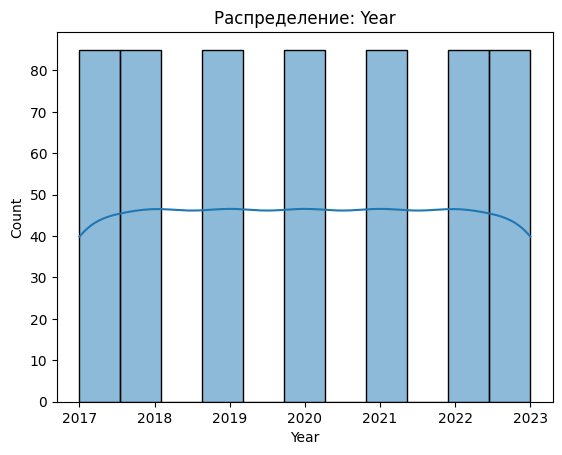

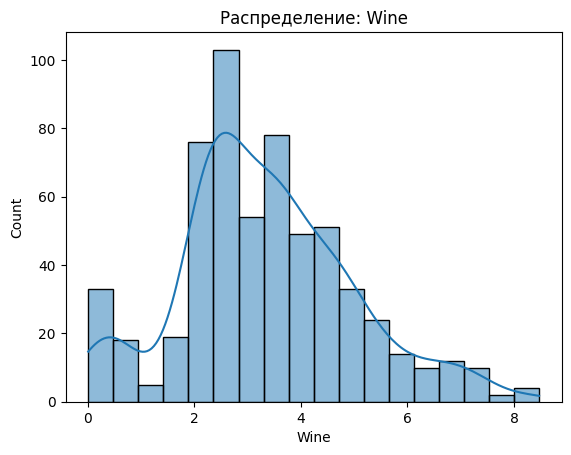

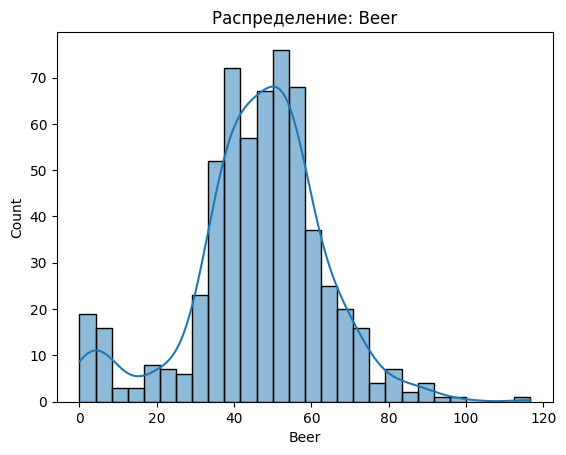

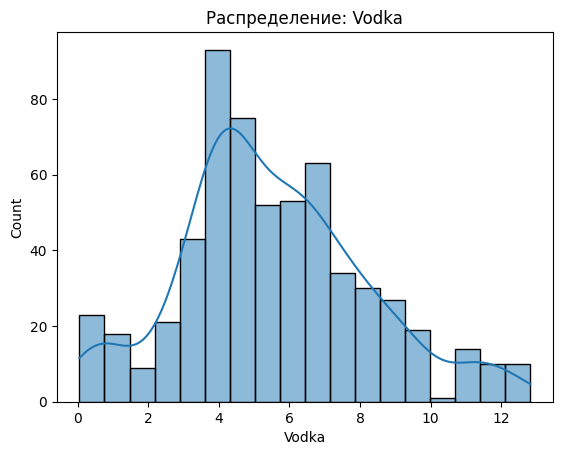

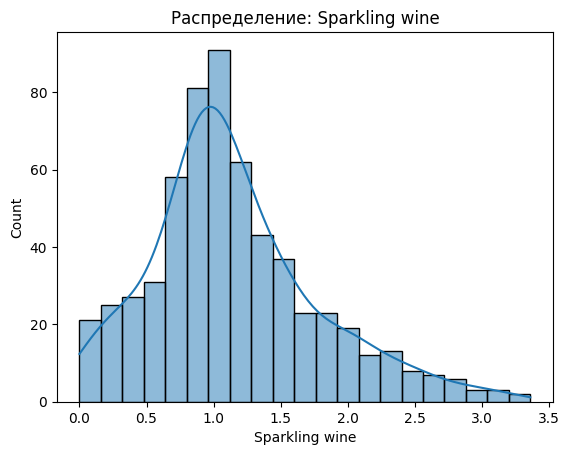

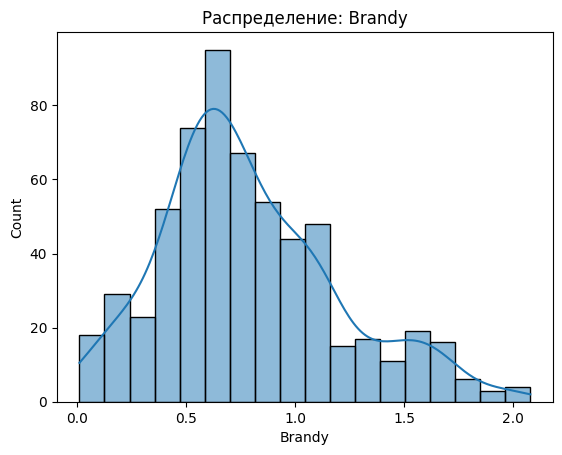

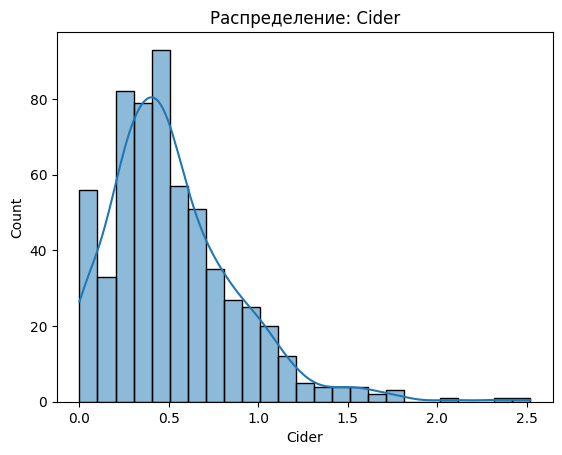

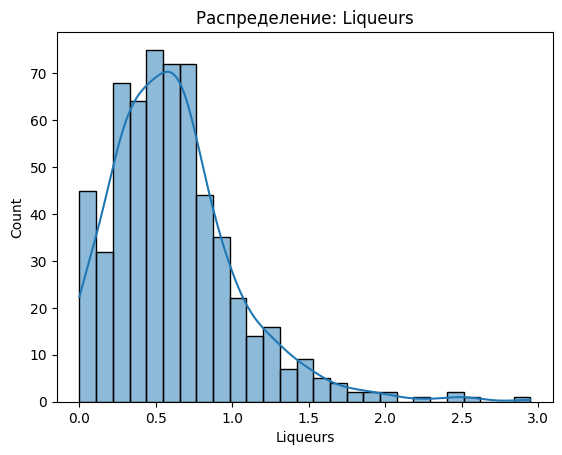

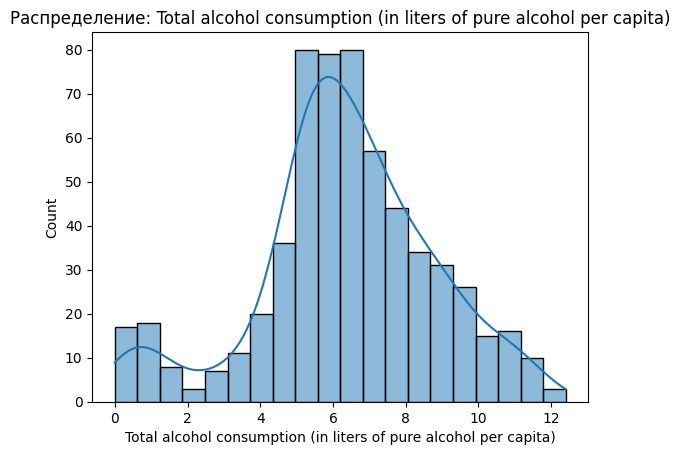

In [4]:
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    sns.histplot(data[column], kde=True)
    plt.title(f"Распределение: {column}")
    plt.show()
    

In [5]:
# Пропущенные значения
missing_values = data.isnull().sum()
print("Пропущенные значения:\n", missing_values)

# Дубликаты
duplicates = data.duplicated().sum()
print(f"Количество дубликатов: {duplicates}")
#Противоречия
def check_inconsistencies(df):
    inconsistencies = []

    # Проверка на аномально низкие или высокие значения потребления
    if df['Total alcohol consumption (in liters of pure alcohol per capita)'].min() < 0 or df['Total alcohol consumption (in liters of pure alcohol per capita)'].max() > 20:
        inconsistencies.append("Аномальные значения потребления алкоголя (менее 1 или более 15).")

    # Проверка логики между годами и значениями (например, проверка, что год не выходит за пределы диапазона)
    if df['Year'].min() < 2000 or df['Year'].max() > 2023:
        inconsistencies.append("Обнаружены некорректные значения года (выходят за пределы 2000–2023).")

    # Возврат результата
    return inconsistencies

# Проверка данных
inconsistencies = check_inconsistencies(data)

# Вывод результата
if inconsistencies:
    print("Обнаружены следующие противоречия:")
    for issue in inconsistencies:
        print(f"- {issue}")
else:
    print("Противоречия не обнаружены.")
# Проверка на некорректные знаки (например, отрицательные значения, если их не должно быть)
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    if (data[col] < 0).any():
        print(f"Обнаружены отрицательные значения в столбце {col}")


Пропущенные значения:
 Region                                                              0
Year                                                                0
Wine                                                                0
Beer                                                                0
Vodka                                                               0
Sparkling wine                                                      0
Brandy                                                              0
Сider                                                               0
Liqueurs                                                            0
Total alcohol consumption (in liters of pure alcohol per capita)    0
dtype: int64
Количество дубликатов: 0
Противоречия не обнаружены.


In [6]:
data['high_consumption'] = (data['Total alcohol consumption (in liters of pure alcohol per capita)'] > data['Total alcohol consumption (in liters of pure alcohol per capita)'].mean()).astype(int)
print(data['high_consumption'].value_counts())

high_consumption
0    298
1    297
Name: count, dtype: int64


In [7]:
# Биннинг по столбцу потребления алкоголя
data['consumption_bins'] = pd.cut(
    data['Total alcohol consumption (in liters of pure alcohol per capita)'],
    bins=5,  # Количество бинов
    labels=["Очень низкое", "Низкое", "Среднее", "Высокое", "Очень высокое"]
)
print(data['consumption_bins'].value_counts())



consumption_bins
Среднее          296
Высокое          135
Низкое            74
Очень низкое      46
Очень высокое     44
Name: count, dtype: int64


consumption_bins
Очень низкое     0.000000
Низкое           0.000000
Среднее          0.398649
Высокое          1.000000
Очень высокое    1.000000
Name: high_consumption, dtype: float64


C:\Users\gorya\AppData\Local\Temp\ipykernel_9244\2005708978.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_analysis = data.groupby('consumption_bins')['high_consumption'].mean()


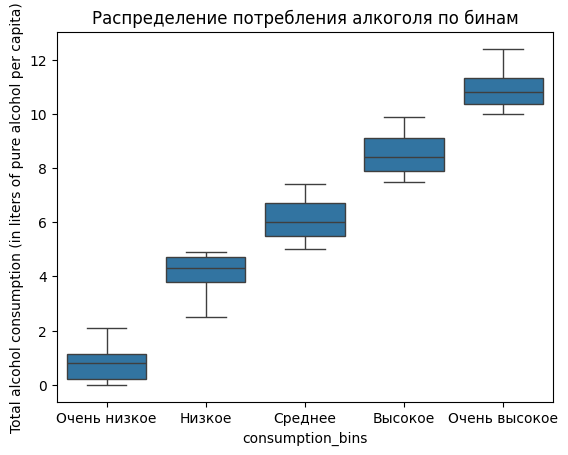

In [8]:
# Группировка и статистика по бинам
bin_analysis = data.groupby('consumption_bins')['high_consumption'].mean()
print(bin_analysis)

# Визуализация распределения
sns.boxplot(x='consumption_bins', y='Total alcohol consumption (in liters of pure alcohol per capita)', data=data)
plt.title("Распределение потребления алкоголя по бинам")
plt.show()


In [9]:
# Выбираем только числовые столбцы
numeric_columns = data.select_dtypes(include=['number'])
correlation = numeric_columns.corr()

# Корреляция с целевым полем
print("Корреляция с целевым полем:\n", correlation['high_consumption'])


Корреляция с целевым полем:
 Year                                                                0.136135
Wine                                                                0.641132
Beer                                                                0.611823
Vodka                                                               0.707638
Sparkling wine                                                      0.557665
Brandy                                                              0.674082
Сider                                                               0.399505
Liqueurs                                                            0.570693
Total alcohol consumption (in liters of pure alcohol per capita)    0.751492
high_consumption                                                    1.000000
Name: high_consumption, dtype: float64


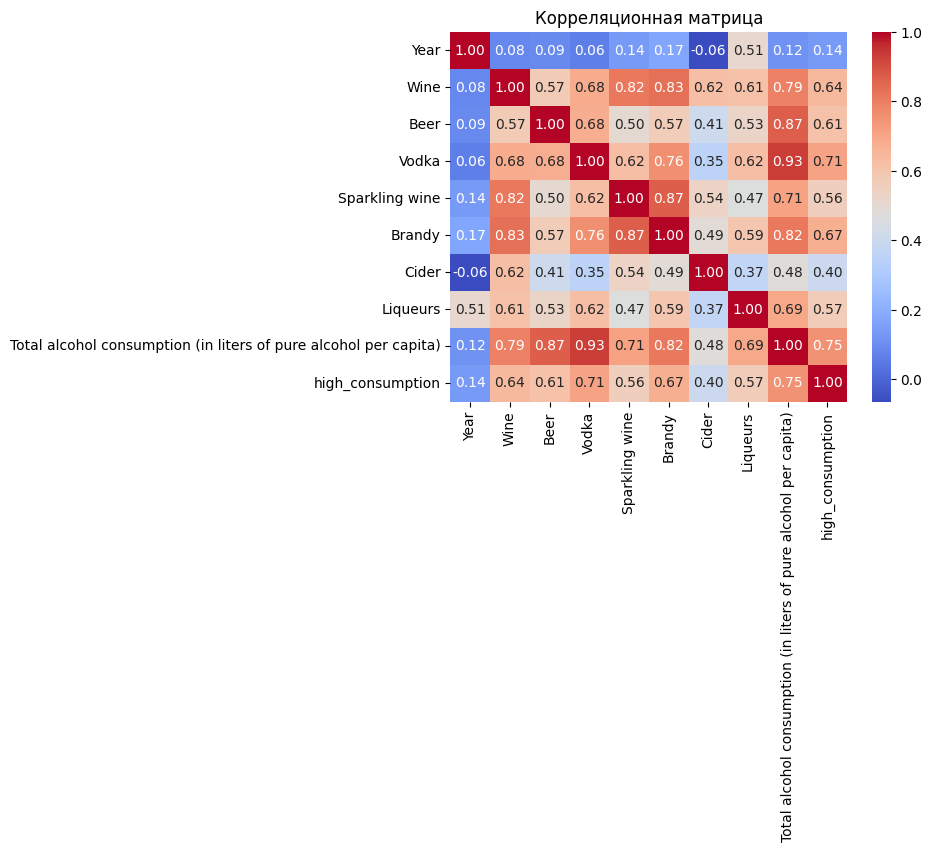

In [10]:
numeric_columns = data.select_dtypes(include=['number'])
correlation_matrix = numeric_columns.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица")
plt.show()


In [11]:
threshold = 0.001
high_corr_features = correlation_matrix[(correlation_matrix.abs() > threshold) & (correlation_matrix.abs() < 1)].stack().reset_index()
print("Значимые коррелирующие признаки:\n", high_corr_features)

Значимые коррелирующие признаки:
              level_0                                            level_1  \
0               Year                                               Wine   
1               Year                                               Beer   
2               Year                                              Vodka   
3               Year                                     Sparkling wine   
4               Year                                             Brandy   
..               ...                                                ...   
85  high_consumption                                     Sparkling wine   
86  high_consumption                                             Brandy   
87  high_consumption                                              Сider   
88  high_consumption                                           Liqueurs   
89  high_consumption  Total alcohol consumption (in liters of pure a...   

           0  
0   0.083081  
1   0.090739  
2   0.063701  
3   0

In [12]:
# Создаем целевую переменную
data['high_consumption'] = (data['Total alcohol consumption (in liters of pure alcohol per capita)'] > data['Total alcohol consumption (in liters of pure alcohol per capita)'].mean()).astype(int)
print(data['high_consumption'])

0      0
1      0
2      1
3      0
4      0
      ..
590    1
591    1
592    1
593    1
594    1
Name: high_consumption, Length: 595, dtype: int64


In [13]:
from sklearn.preprocessing import LabelEncoder

# Кодирование категориального признака region
data['region_encoded'] = LabelEncoder().fit_transform(data['Region'])


In [14]:
X = data[['region_encoded']]
y = data['high_consumption']

In [15]:
from sklearn.model_selection import train_test_split

# Деление данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [16]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Инициализация моделей
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Обучение и оценка
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


--- Random Forest ---
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90        90
           1       0.91      0.89      0.90        89

    accuracy                           0.90       179
   macro avg       0.90      0.90      0.90       179
weighted avg       0.90      0.90      0.90       179

Confusion Matrix:
 [[82  8]
 [10 79]]
--- Gradient Boosting ---
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        90
           1       0.88      0.88      0.88        89

    accuracy                           0.88       179
   macro avg       0.88      0.88      0.88       179
weighted avg       0.88      0.88      0.88       179

Confusion Matrix:
 [[79 11]
 [11 78]]
--- Logistic Regression ---
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.56      0.53        90
           1 

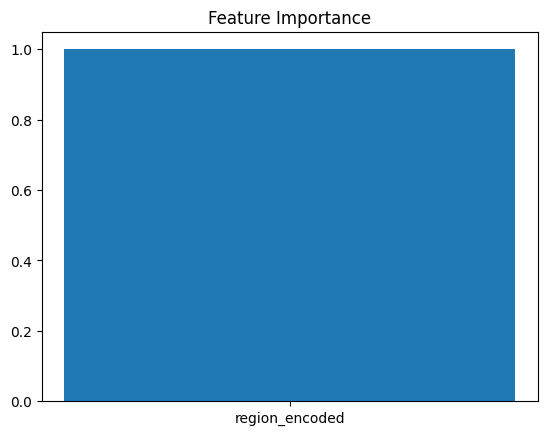

In [17]:
# Важность признаков для Random Forest
import matplotlib.pyplot as plt

rf_model = models['Random Forest']
importance = rf_model.feature_importances_

plt.bar(['region_encoded'], importance)
plt.title('Feature Importance')
plt.show()
